In [28]:
#importing necessary libraries
import numpy as np
import scipy
import scipy.stats.stats as stat
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib
import seaborn as sb
from io import StringIO
import re
import matplotlib.pyplot as plt
import pandas as pd
import urllib3 as urllib
import csv
from sklearn.model_selection import train_test_split

%matplotlib inline

<h2>Downloading and Processing the Data</h2>

In [29]:
'''
Downloading the Data 
-Retrieve the echocardiogram data from the web address.
-Load the Data into a pandas dataframe
'''

# load in the data locally
with open('echocardiogram.data.txt') as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split(',')
      newLines.append( newLine )

with open('ecgData.csv', 'w') as test_file:
   file_writer = csv.writer(test_file)
   file_writer.writerows( newLines )
    
#Read the data into a pandas dataframe

columnNames = ['survival','still-alive','age-at-heart-attack','pericardial-effusion','fractional-shortening','epss','lvdd','wall-motion-score','wall-motion-index','mult','name','group','alive-at-1']
table = pd.read_csv('ecgData.csv',names=columnNames)

#Clear the useless columns:

uselessCols = ['mult','name','group']
table.drop(uselessCols, inplace=True, axis=1)
               
table

table = table.apply(pd.to_numeric, errors='coerce')

# Validate the data
def check_column(data,col):
    data[col] = data[col].replace('?',np.nan)
    return data[col]
#b)
def validate(data):
    for column in data:
        data[column]= check_column(data,column)
    return data

table = validate(table)

# Remove all na values:
table = table.dropna(axis=0, how='any')
table.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
0,11.0,0.0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0
1,19.0,0.0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0
2,16.0,0.0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0
3,57.0,0.0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0
4,19.0,1.0,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0


In [30]:
# Output Column (Can we predict if the patient is alive after 1 year?)
y = table[['still-alive']]
#Factors used to predict the output
x = table[['age-at-heart-attack','fractional-shortening','lvdd','wall-motion-score']]

# Data Exploration with PCA:

In [31]:
# standardize the variables for which we will apply PCA

x_std = StandardScaler().fit_transform(x)

#apply PCA

pca = PCA(n_components=2)
pca.fit(x)

x_pca = pca.transform(x)

print('Components:\n {}\n\n'.format(pca.components_))

print('Explained Variance\n PC 1: {}\n PC 2: {}'.format(pca.explained_variance_[0],pca.explained_variance_[1]))

Components:
 [[ 0.99823634 -0.00134147  0.01682984 -0.05691371]
 [ 0.05639108 -0.00565935  0.02959334  0.99795403]]


Explained Variance
 PC 1: 75.82170764249852
 PC 2: 29.28872393729144


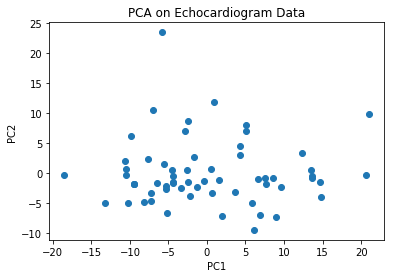

In [32]:
#Use the reduced dimension x-values obtained by the PCA to perform the linear regression

plt.scatter([x[0] for x in x_pca],[x[1] for x in x_pca])
plt.title('PCA on Echocardiogram Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

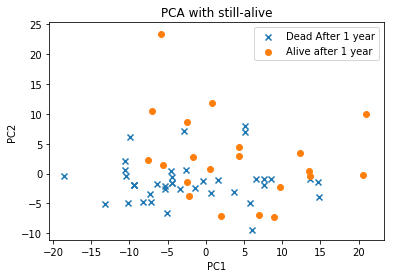

In [33]:
#Add markers to indicate dead or alive after 1 year

dead = []
alive = []

i = 0

for index, row in y.iterrows():

    
    pcs = list(x_pca[i])
    
    if row['still-alive'] == 0.0:
        
        #indicates patient has died
        dead.append(pcs)
    else:
        
        alive.append(pcs)
    
    
    i += 1
    
plt.scatter([x[0] for x in dead],[x[1] for x in dead],marker='x')
plt.scatter([x[0] for x in alive],[x[1] for x in alive],marker='o')
plt.title('PCA with still-alive')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labels=['Dead After 1 year','Alive after 1 year'])
plt.show()

# Logistic Regression:


In [34]:
#Split into 5 different test-train sets

xtrain1, xtest1 = train_test_split(x, test_size=0.2,random_state = 1)
ytrain1, ytest1 = train_test_split(y, test_size=0.2,random_state = 1)

xtrain2, xtest2 = train_test_split(x, test_size=0.2,random_state = 2)
ytrain2, ytest2 = train_test_split(y, test_size=0.2,random_state = 2)

xtrain3, xtest3 = train_test_split(x, test_size=0.2,random_state = 3)
ytrain3, ytest3 = train_test_split(y, test_size=0.2,random_state = 3)

xtrain4, xtest4 = train_test_split(x, test_size=0.2,random_state = 6)
ytrain4, ytest4 = train_test_split(y, test_size=0.2,random_state = 6)

xtrain5, xtest5 = train_test_split(x, test_size=0.2,random_state = 5)
ytrain5, ytest5 = train_test_split(y, test_size=0.2,random_state = 5)

#Run Logistic Regression on different combinations of each data set


from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

tot_accuracy = 0

for i in range(4):
    xtrainframes = [xtest1,xtest2,xtest3,xtest4,xtest5]
    ytrainframes = [ytest1,ytest2,ytest3,ytest4,ytest5]
    xtrainframes.pop(i)
    ytrainframes.pop(i)
    
    x_test = pd.concat(xtrainframes)
    x_train = xtrainframes[i]
    y_test = pd.concat(ytrainframes)
    y_train = ytrainframes[i]
    

    logreg.fit(x_train,y_train.values.ravel())
    tot_accuracy+=logreg.score(x_test,y_test)  
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test,y_test)))

print('Average Accuracy of logistic regression classifier on test sets: {:.2f}'.format(tot_accuracy/4))

Accuracy of logistic regression classifier on test set: 0.77
Accuracy of logistic regression classifier on test set: 0.81
Accuracy of logistic regression classifier on test set: 0.73
Accuracy of logistic regression classifier on test set: 0.77
Average Accuracy of logistic regression classifier on test sets: 0.77


# ROC

0.675


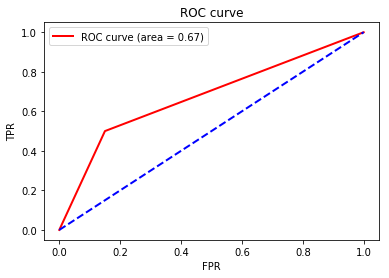

In [40]:
#ROC 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
fpr, tpr,_=roc_curve(logreg.predict(pd.concat(xtrainframes)),pd.concat(ytrainframes),drop_intermediate=False)
plt.figure()
plt.plot(fpr, tpr, color='red',
 lw=2,label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
print(metrics.auc(fpr,tpr))
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()